In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [9]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [19]:
class Autoencoder(nn.Module):
  def __init__(self): # N - batch size, 784*784 is the size of the image
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,128),  # N,784
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,12),
        nn.ReLU(),
        nn.Linear(12,3)# N,3
    )
    self.decoder = nn.Sequential(
    nn.Linear(3,12),# N,3
    nn.ReLU(),
    nn.Linear(12,64),
    nn.ReLU(),
    nn.Linear(64,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,784),# N by 784
    nn.Sigmoid()#classification head
    )


  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class Autoencoder(nn.Module): # USE CONV2D for the same
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [20]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [21]:
num_epochs = 25
outputs = []
for epoch in range(num_epochs):
  for img,_ in data_loader:# This loads batches of data, not single examples
      img = img.reshape(-1,28*28)# Reshaping the batch
      recon = model(img) # Forward pass on the entire batch
      loss = criterion(recon,img)
      optimizer.zero_grad()# Reset gradients
      loss.backward()# Backpropagation for the batch
      optimizer.step()# Update weights for the batch
  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0518
Epoch:2, Loss:0.0394
Epoch:3, Loss:0.0338
Epoch:4, Loss:0.0366
Epoch:5, Loss:0.0396
Epoch:6, Loss:0.0327
Epoch:7, Loss:0.0320
Epoch:8, Loss:0.0325
Epoch:9, Loss:0.0319
Epoch:10, Loss:0.0332
Epoch:11, Loss:0.0357
Epoch:12, Loss:0.0313
Epoch:13, Loss:0.0326
Epoch:14, Loss:0.0334
Epoch:15, Loss:0.0319
Epoch:16, Loss:0.0303
Epoch:17, Loss:0.0337
Epoch:18, Loss:0.0329
Epoch:19, Loss:0.0279
Epoch:20, Loss:0.0350
Epoch:21, Loss:0.0302
Epoch:22, Loss:0.0312
Epoch:23, Loss:0.0314
Epoch:24, Loss:0.0278
Epoch:25, Loss:0.0267


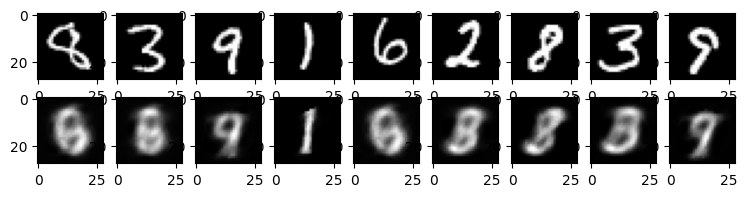

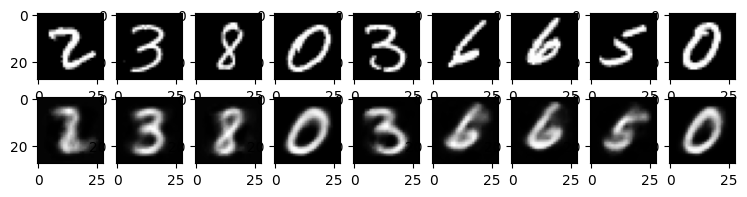

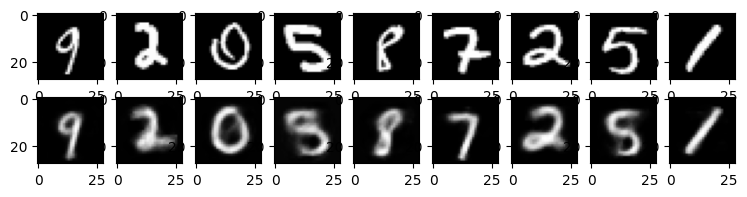

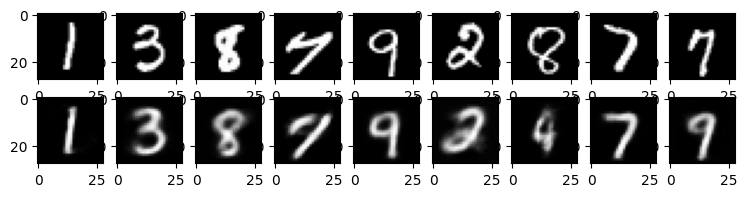

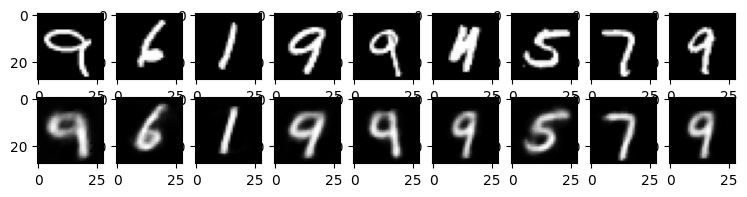

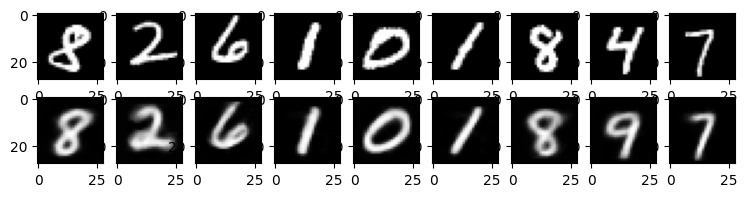

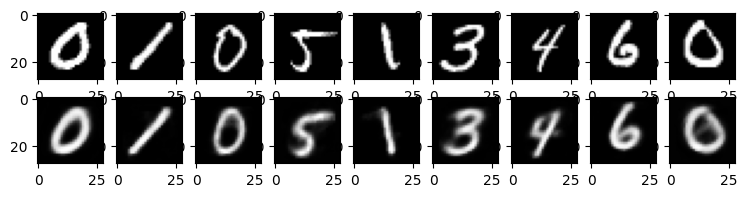

In [30]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])